<a href="https://colab.research.google.com/github/victoriaribeiro/movie-ratings-prediction/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import altair as alt
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
plt.style.use('seaborn')
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/dbs

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/dbs


#Preparação

In [12]:
df_ratings = pd.read_csv("ratings_100k.CSV",sep=';', usecols=['userId', 'itemId', 'rating'])
df_ratings.head()
df_movies_cnt = pd.DataFrame(df_ratings.groupby('itemId').size(), columns=['count'])
df_movies_cnt = df_movies_cnt.sort_values('count', ascending=False)
df_movies_cnt.head(n=10)

,count
itemId,
50,583
258,509
100,508
181,507
294,485
286,481
288,478
1,452
300,431


In [0]:
matrix_ratings = df_ratings.pivot(index='itemId', columns='userId', values='rating').fillna(0)
matrix_ratings = matrix_ratings.values
matrix_ratings_nan = np.copy(matrix_ratings)
matrix_ratings_nan[matrix_ratings==0] = np.nan
landmarks = []

`matrix_ratings` é a matriz com as notas de todos os usuários.

In [0]:
def media_array(a):
    a = np.asarray(a)    
    for index, i in enumerate(a):
        i = np.asarray(i)
        a[index] = np.mean(i)
        
    return np.mean(a)

In [0]:
def eucl_dist(a,b):
    return(np.sqrt(np.nansum((a-b)**2)))

In [0]:
def distancia_entre_land_item(target, landmarks):
    matrix_dist = []
    for i in target:
        temp = []
        for j in landmarks:
            eucl = eucl_dist(i,matrix_ratings[j])
            temp.append(eucl)
        matrix_dist.append(temp)
    matrix_dist = np.asarray(matrix_dist)
    return matrix_dist

In [0]:
def distancia_entre_land_user(target, landmarks):
    matrix_dist = []
    for i in target:
        temp = []
        for j in landmarks:
            eucl = eucl_dist(i,matrix_ratings.T[j])
            temp.append(eucl)
        matrix_dist.append(temp)
    matrix_dist = np.asarray(matrix_dist)
    return matrix_dist

#Dataset de 100k


##Landmarks

###Encontrando a quantidade ótima de vizinhos

####Item Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 200

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)



for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_item(treino, landmarks)
        teste_dist = distancia_entre_land_item(teste,landmarks)

        
        for k in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[k] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[k] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [k]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [k]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



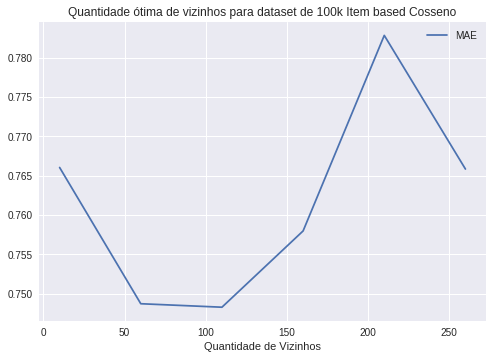

In [19]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


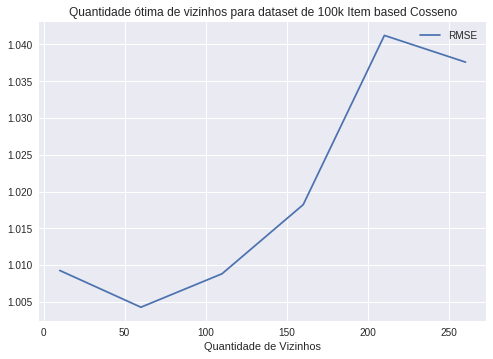

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 200

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_item(treino, landmarks)
        teste_dist = distancia_entre_land_item(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



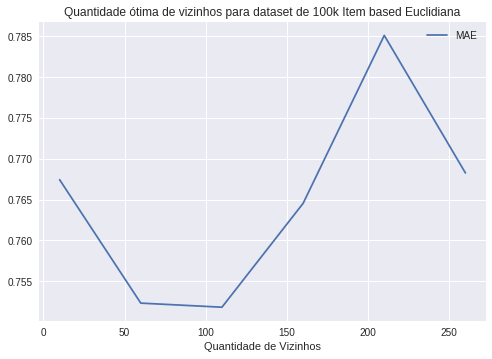

In [0]:
plt.plot(x,mae_total, label='MAE')

plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

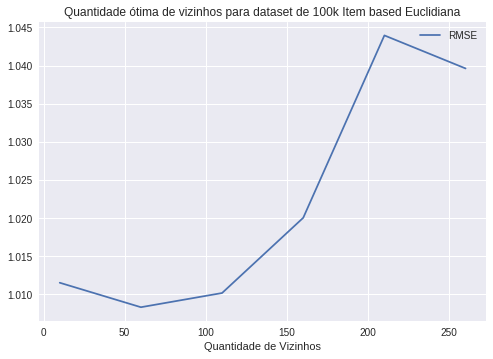

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

####User Based Coseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 200

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]
        

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_user(treino, landmarks)
        teste_dist = distancia_entre_land_user(teste,landmarks)
       

        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



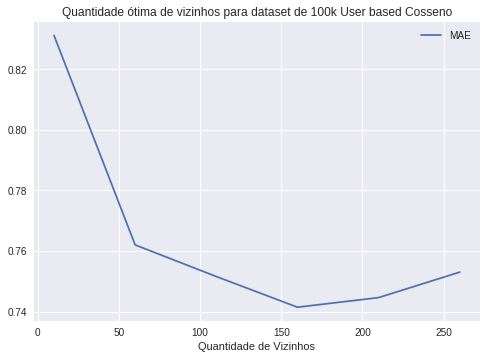

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

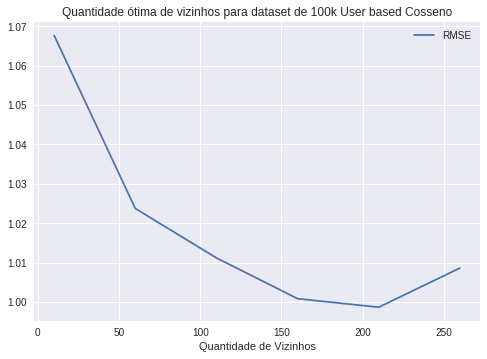

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

####User Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 200

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_user(treino, landmarks)
        teste_dist = distancia_entre_land_user(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



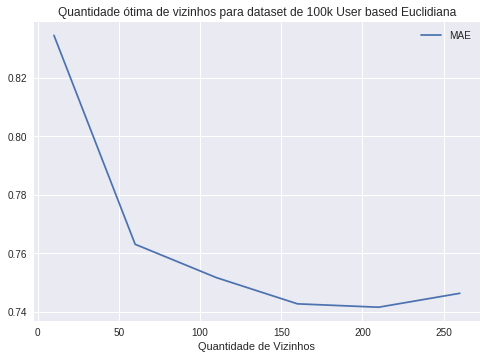

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Euclidiana')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

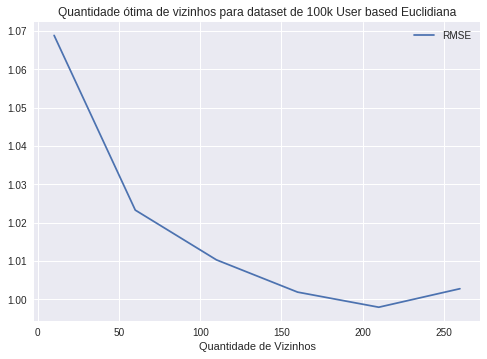

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Euclidiana')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()

###Encontrando a quantidade ótima de Landmarks

####Item Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(1,10,2)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_item(treino, landmarks)
        teste_dist = distancia_entre_land_item(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []

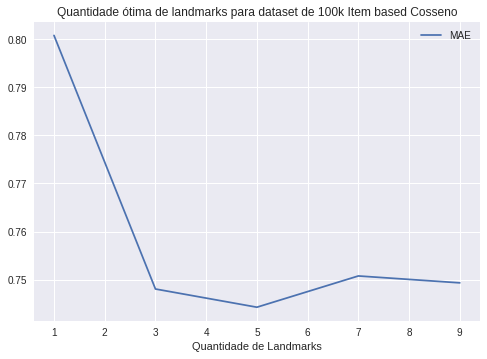

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de landmarks para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

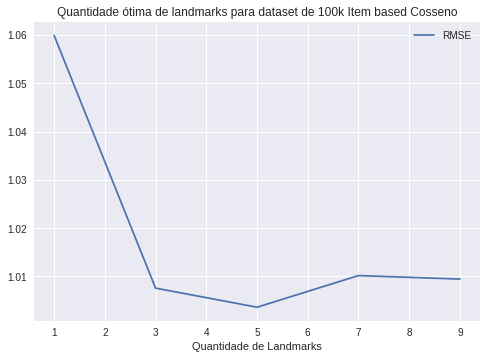

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de landmarks para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

####Item Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_item(treino, landmarks)
        teste_dist = distancia_entre_land_item(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []

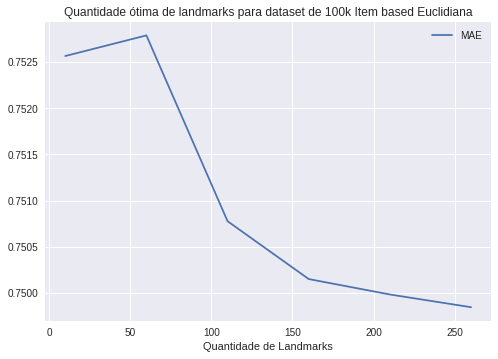

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de landmarks para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

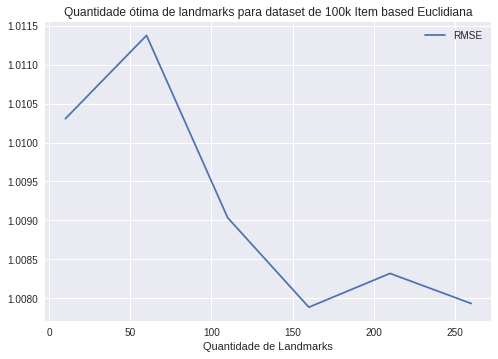

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de landmarks para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

####User Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 210

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_user(treino, landmarks)
        teste_dist = distancia_entre_land_user(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



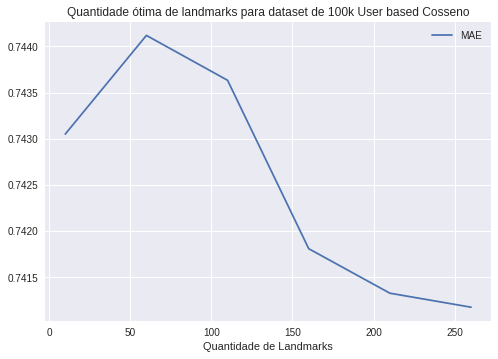

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de landmarks para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

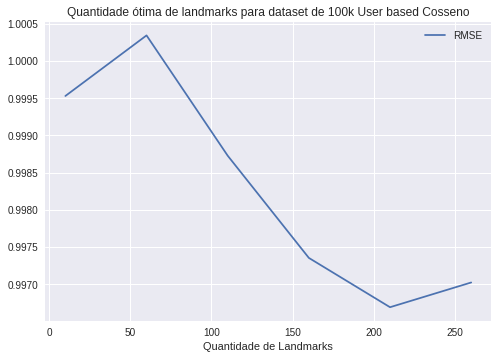

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de landmarks para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

####User Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 210

n_land = 40

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_user(treino, landmarks)
        teste_dist = distancia_entre_land_user(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



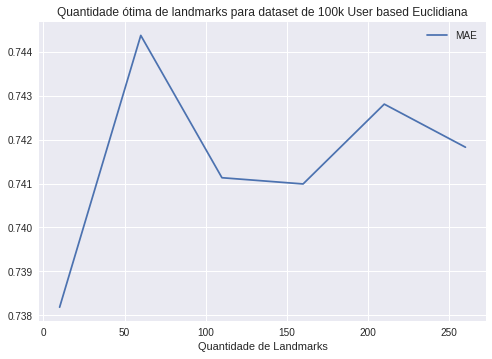

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de landmarks para dataset de 100k User based Euclidiana')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

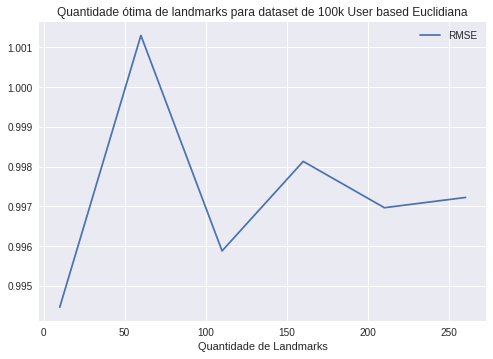

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de landmarks para dataset de 100k User based Euclidiana')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

##PCA

###Encontrando a quatidade ótima de vizinhos

####Item Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



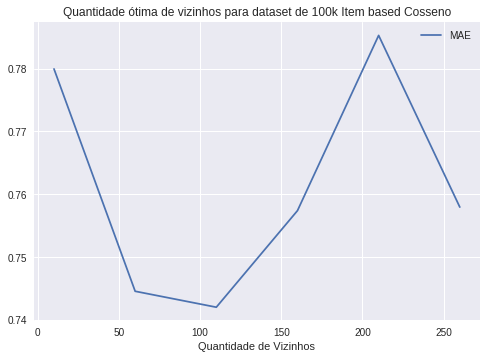

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


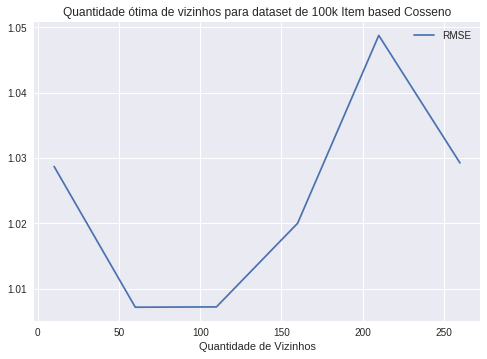

In [0]:
plt.plot(x,rmse_total, label='RMSE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


####Item Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 60


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



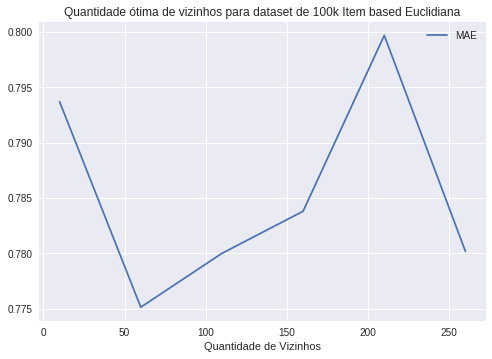

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


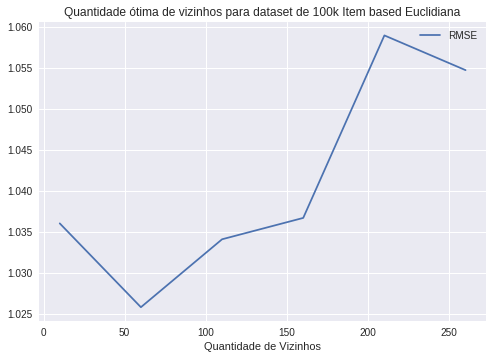

In [0]:
plt.plot(x,rmse_total, label='RMSE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


####User Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



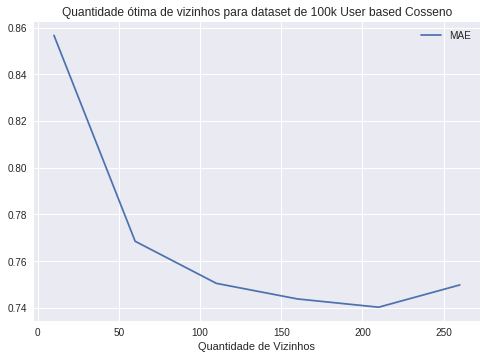

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


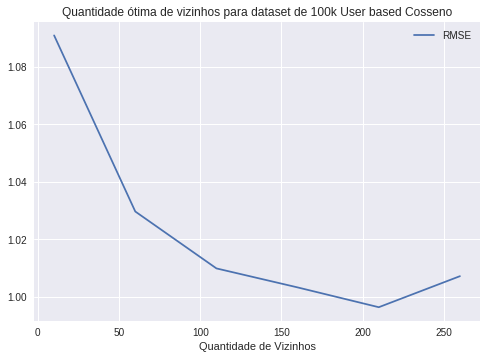

In [0]:
plt.plot(x,rmse_total, label='RMSE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


####User Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(10,261,50)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



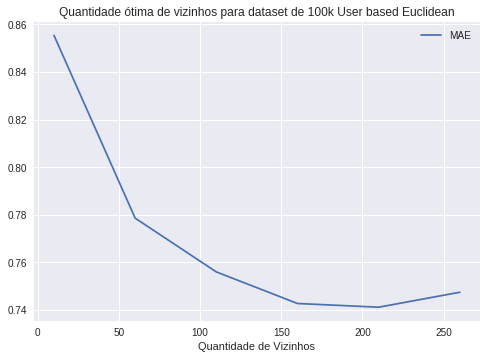

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Euclidean')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


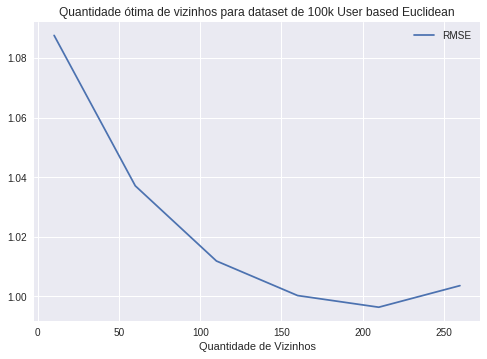

In [0]:
plt.plot(x,rmse_total, label='RMSE')
plt.title('Quantidade ótima de vizinhos para dataset de 100k User based Euclidean')
plt.xlabel("Quantidade de Vizinhos")
plt.legend()


###Encontrando a quantidade ótima de componentes

####Item Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 60


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(2,12,2)

for n_comp in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



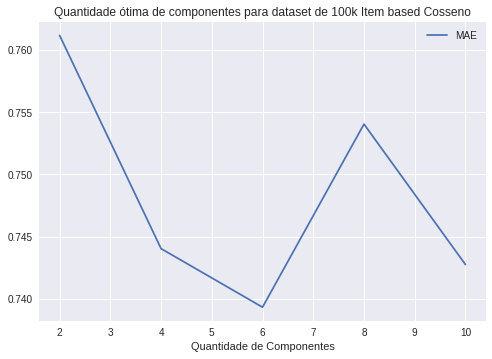

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de componentes para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

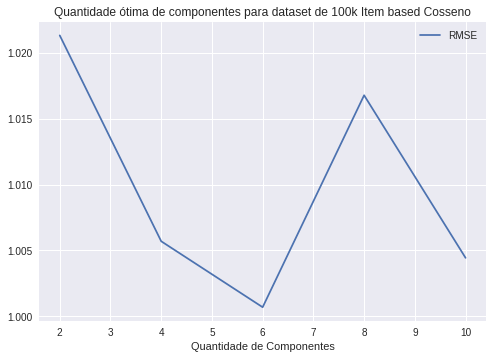

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de componentes para dataset de 100k Item based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

####Item Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(2,12,2)

for n_comp in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



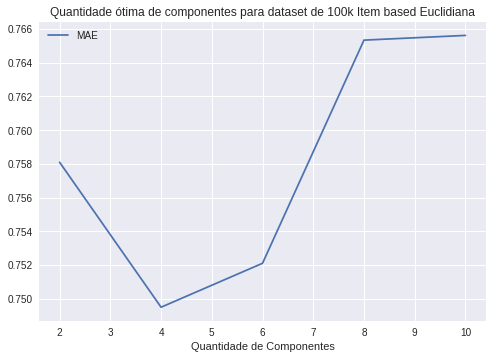

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de componentes para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Componentes")
plt.legend()

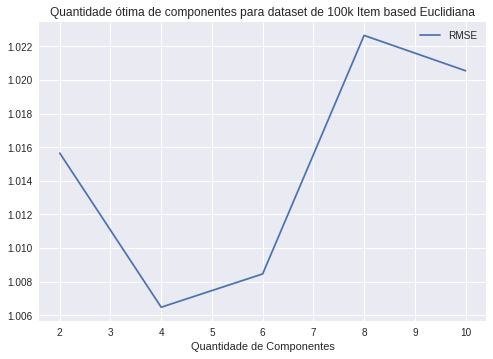

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de componentes para dataset de 100k Item based Euclidiana')
plt.xlabel("Quantidade de Componentes")
plt.legend()

####User Based Cosseno

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(2,12,2)


for n_comp in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



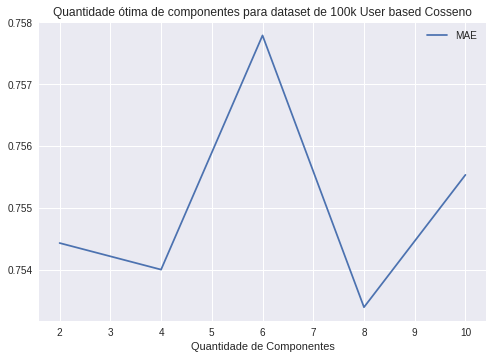

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de componentes para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

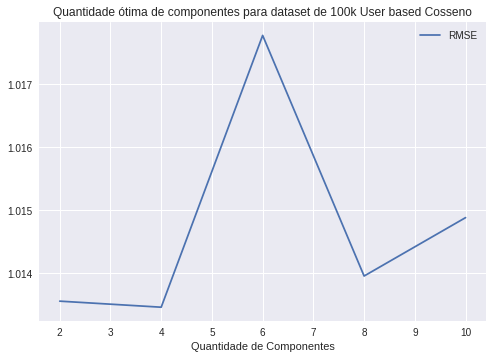

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de componentes para dataset de 100k User based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

####User Based Euclidiana

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 110


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(2,12,2)



for n_comp in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='euclidean', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



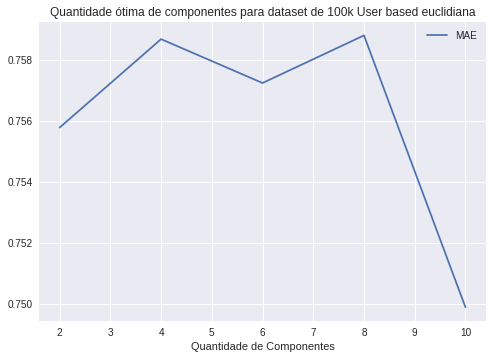

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de componentes para dataset de 100k User based euclidiana')
plt.xlabel("Quantidade de Componentes")
plt.legend()

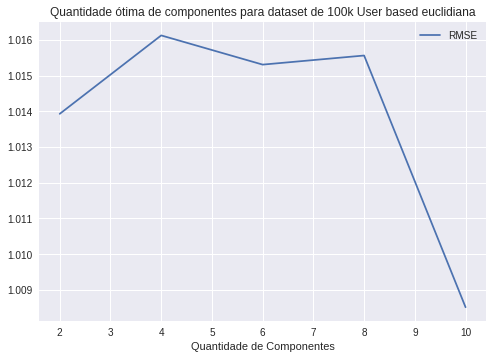

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de componentes para dataset de 100k User based euclidiana')
plt.xlabel("Quantidade de Componentes")
plt.legend()

##Melhores parâmetros

#Dataset de 1M

##Preparação

In [0]:
df_ratings = pd.read_csv("ratings_1m.csv",sep=';', usecols=['userId', 'itemId', 'rating'])
df_ratings.head()
df_movies_cnt = pd.DataFrame(df_ratings.groupby('itemId').size(), columns=['count'])
df_movies_cnt = df_movies_cnt.sort_values('count', ascending=False)
df_movies_cnt.head(n=10)

,count
itemId,
2858,3428
260,2991
1196,2990
1210,2883
480,2672
2028,2653
589,2649
2571,2590
1270,2583


In [0]:
matrix_ratings = df_ratings.pivot(index='itemId', columns='userId', values='rating').fillna(0)
matrix_ratings = matrix_ratings.values
matrix_ratings_nan = np.copy(matrix_ratings)
matrix_ratings_nan[matrix_ratings==0] = np.nan
landmarks = []

In [0]:
def distancia_entre_land_item(target, landmarks):
    matrix_dist = []
    for i in target:
        temp = []
        for j in landmarks:
            eucl = eucl_dist(i,matrix_ratings[j])
            temp.append(eucl)
        matrix_dist.append(temp)
    matrix_dist = np.asarray(matrix_dist)
    return matrix_dist

In [0]:
def distancia_entre_land_user(target, landmarks):
    matrix_dist = []
    for i in target:
        temp = []
        for j in landmarks:
            eucl = eucl_dist(i,matrix_ratings.T[j])
            temp.append(eucl)
        matrix_dist.append(temp)
    matrix_dist = np.asarray(matrix_dist)
    return matrix_dist

##Vizinhos

###Item Based

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 200

n_land = 110

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(1050,1651,200)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_item(treino, landmarks)
        teste_dist = distancia_entre_land_item(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



KeyboardInterrupt: ignored

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 1M Item based')
plt.xlabel("Quantidade de vizinhos")
plt.legend()

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de vizinhos para dataset de 1M Item based')
plt.xlabel("Quantidade de vizinhos")
plt.legend()

###User Based

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 200

n_land = 7

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(1050,1651,200)


for n_vizinhos in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_user(treino, landmarks)
        teste_dist = distancia_entre_land_user(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



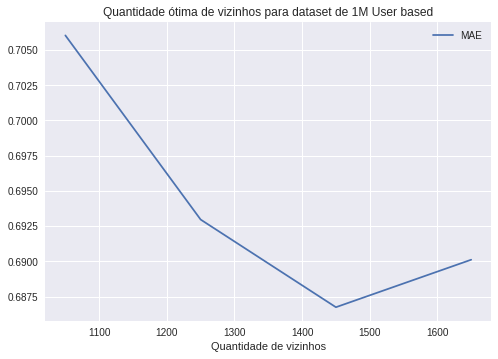

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de vizinhos para dataset de 1M User based')
plt.xlabel("Quantidade de vizinhos")
plt.legend()

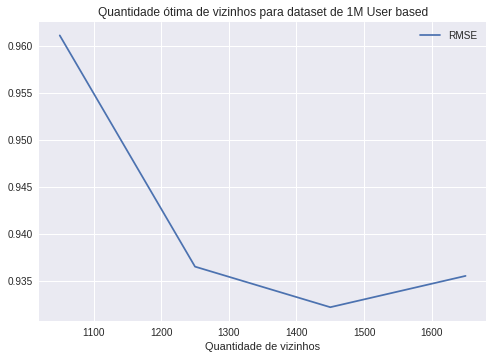

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de vizinhos para dataset de 1M User based')
plt.xlabel("Quantidade de vizinhos")
plt.legend()

##Landmarks

###Item Based

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 1600

n_land = 110

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(50,351,100)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_item(treino, landmarks)
        teste_dist = distancia_entre_land_item(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



KeyboardInterrupt: ignored

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de landmarks para dataset de 1M Item based Cosseno')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de landmarks para dataset de 1M Item based Cosseno')
plt.xlabel("Quantidade de Landmarks")
plt.legend()

###User Based

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 1600

n_land = 110

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(50,351,100)


for n_land in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]

        count = np.count_nonzero(treino, axis=1)

        landmarks = np.argsort(count)
        landmarks = landmarks[-n_land:]        
        matrix_dist = distancia_entre_land_user(treino, landmarks)
        teste_dist = distancia_entre_land_user(teste,landmarks)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



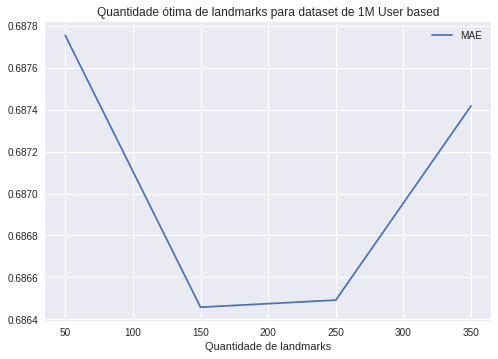

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de landmarks para dataset de 1M User based')
plt.xlabel("Quantidade de landmarks")
plt.legend()

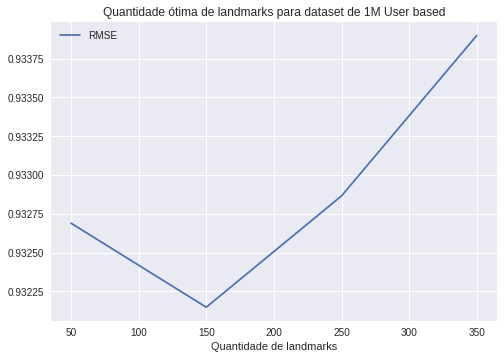

In [0]:
plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de landmarks para dataset de 1M User based')
plt.xlabel("Quantidade de landmarks")
plt.legend()

##PCA

###Item Based

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 1600


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(2,17,5)


for n_comp in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings[i]
        teste = matrix_ratings[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de componentes para dataset de 1M Item based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de componentes para dataset de 1M Item based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

###User Based

In [0]:
rkf = RepeatedKFold(n_splits=5, n_repeats=1)
n_vizinhos = 1600


n_comp = 55

mae = []
rmse = []
mae_total = []
rmse_total = []

x = range(2,17,5)


for n_comp in x:
    neigh = KNeighborsRegressor(n_neighbors=n_vizinhos, metric='cosine', n_jobs=1)
    temp = []
    temp2 = []
    for i, j in rkf.split(matrix_ratings.T):
        pca = PCA(n_components=n_comp)
        
        treino = matrix_ratings.T[i]
        teste = matrix_ratings.T[j]


        matrix_dist = pca.fit_transform(treino)
        
        teste_dist = pca.fit_transform(teste)


        for i in (range(treino.shape[1])):
            indices_rated = np.argwhere(treino.T[i] != 0).reshape(-1)
            indices_teste_rated = np.argwhere(teste.T[i] != 0).reshape(-1)
            if(indices_rated.size >= n_vizinhos and indices_teste_rated.size):
                knn_matrix = []
                treino_knn = matrix_dist[indices_rated]
                labels = treino[indices_rated, [i]]
                neigh.fit(treino_knn, labels)

                knn_teste_matrix = teste_dist[indices_teste_rated]
                real_values = teste[indices_teste_rated, [i]]


                predictions = neigh.predict(knn_teste_matrix)
                predictions = np.around(predictions)
                predictions[predictions == 0] = 1
                predictions[predictions > 5] = 5

                temp.append(mean_absolute_error(real_values, predictions))
                temp2.append(np.sqrt(mean_squared_error(real_values, predictions)))

        mae.append(media_array(temp))
        rmse.append(media_array(temp2))
        temp = []
        temp2 = []
    mae_total.append(media_array(mae))
    rmse_total.append(media_array(rmse))
    mae = []
    rmse = []
    



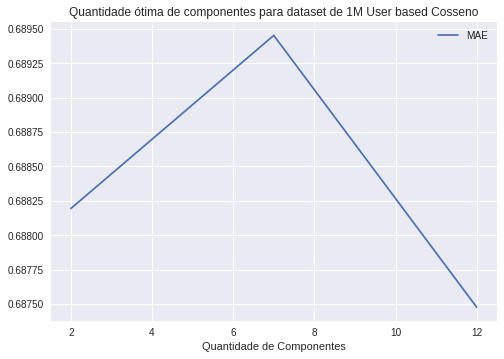

In [0]:
plt.plot(x,mae_total, label='MAE')
plt.title('Quantidade ótima de componentes para dataset de 1M User based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

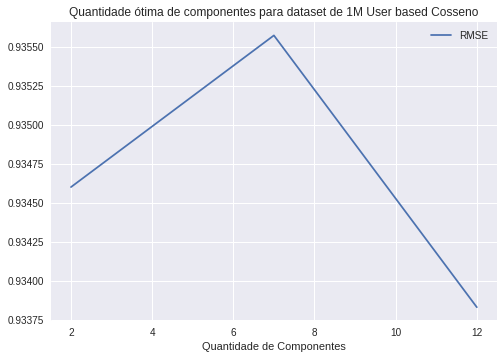

In [0]:

plt.plot(x,rmse_total, label="RMSE")
plt.title('Quantidade ótima de componentes para dataset de 1M User based Cosseno')
plt.xlabel("Quantidade de Componentes")
plt.legend()

#Resultados

##Dataset de 100K

###Valores ótimos de vizinhos

O valor em negrito apresenta o melhor resultado entre todos

|            	| Landmarks 	| Landmarks  	| PCA     	| PCA        	|
|------------	|-----------	|------------	|---------	|------------	|
|            	| Cosseno   	| Euclidiana 	| Cosseno 	| Euclidiana 	|
| item based 	| 60        	| 60         	| 110     	| 60         	|
| user based 	| 160       	| 210        	| 210     	| 210        	|

###Valores ótimos de Landmarks
O valor em negrito apresenta o melhor resultado entre todos

|            	| Cosseno 	| Euclidiana 	|
|------------	|---------	|------------	|
| item based 	| 5       	| 160        	|
| user based 	| 210     	| 5          	|

###Valores ótimos de componentes
O valor em negrito apresenta o melhor resultado entre todos

|            	| Cosseno 	| Euclidiana 	|
|------------	|---------	|------------	|
| item based 	| 6       	| 4          	|
| user based 	| 8       	| 10         	|

###Melhores Resultados

|            	| PCA   	| Landmark 	|
|------------	|-------	|----------	|
| User Based 	| 0.737 	| 0.741    	|
| Item Based 	| 0.738 	| 0.746    	|

##Dataset de 1M

###Valores ótimos de vizinhos

|            	| PCA 	| Landmarks 	|
|------------	|-----	|-----------	|
| User Baser 	| -   	| 1600      	|
| Item Based 	| -   	| 1600      	|

###Melhores Resultados